In [218]:
%load_ext autoreload
% autoreload 2
import seaborn
%matplotlib inline
%pylab
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
from pylab import rcParams
rcParams['figure.figsize'] = 11, 4
seaborn.set_style("whitegrid")
seaborn.despine()

%aimport -numpy as np
from optalg.opt_solver import OptSolverIQP, QuadProblem, OptSolverLCCP
from scipy.sparse import triu, bmat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [219]:
from mppfnet.mp_network import MPNetwork
from mppfnet.mp_problem import MPProblem
import gridopt
import pfnet

In [220]:
mp = MPNetwork()
mp.load('./data/case32.art')

In [221]:
mp.networks[0].show_properties()


Network Properties
------------------
bus v max   : 1.00     (p.u.)
bus v min   : 1.00     (p.u.)
bus v vio   : 0.02     (p.u.)
bus P mis   : 2.65e+01 (MW)
bus Q mis   : 1.35e+01 (MVAr)
gen P cost  : 0.00e+00 ($/hr)
gen v dev   : 0.00e+00 (p.u.)
gen Q vio   : 0.00e+00 (MVAr)
gen P vio   : 0.00e+00 (MW)
tran v vio  : 2.00e-02 (p.u.)
tran r vio  : 0.00e+00       
tran p vio  : 0.00e+00 (rad)
shunt v vio : 0.00e+00 (p.u.)
shunt b vio : 0.00e+00 (p.u.)
load P util : -1.10e+03 ($/hr)
load P vio  : 0.00e+00 (MW)
num actions : 0



In [222]:
mp.set_prices()

# Load Profiles
mp.generate_load_profiles()

# bus voltage angles
mp.set_flags(pfnet.OBJ_BUS, pfnet.FLAG_VARS, pfnet.BUS_PROP_NOT_SLACK, pfnet.BUS_VAR_VANG)

# Batteries must be variables
mp.set_flags(pfnet.OBJ_BAT, pfnet.FLAG_VARS, pfnet.BAT_PROP_ANY, pfnet.BAT_VAR_P)
mp.set_flags(pfnet.OBJ_BAT, pfnet.FLAG_VARS, pfnet.BAT_PROP_ANY, pfnet.BAT_VAR_E)

# slack gens active powers
mp.set_flags(pfnet.OBJ_GEN, pfnet.FLAG_VARS, pfnet.GEN_PROP_SLACK,pfnet.GEN_VAR_P)

# gens active powers
mp.set_flags(pfnet.OBJ_GEN,pfnet.FLAG_BOUNDED,pfnet.GEN_PROP_ANY,pfnet.GEN_VAR_P)

# Battery Bounds
mp.set_flags(pfnet.OBJ_BAT,pfnet.FLAG_BOUNDED,pfnet.BAT_PROP_ANY,pfnet.BAT_VAR_P)
mp.set_flags(pfnet.OBJ_BAT,pfnet.FLAG_BOUNDED,pfnet.BAT_PROP_ANY,pfnet.BAT_VAR_E)

p = MPProblem(mp)
p.add_function(pfnet.FUNC_TYPE_NETCON_COST, 1.0)
p.add_constraint(pfnet.CONSTR_TYPE_LBOUND)  # generator bounds
p.add_constraint(pfnet.CONSTR_TYPE_DCPF)  # power flow
p.analyze()
x = p.get_init_point()
p.eval(x)
p.construct_problem()

In [223]:
Hx = p.Hphi + p.Hphi.T - triu(p.Hphi)
gx = p.gphi - Hx*x

g = gx / mp.base_power
H = Hx / mp.base_power
A = p.A
b = p.b
l = p.l
u = p.u

problem = QuadProblem(H, g, A, b, l, u)
solver = OptSolverLCCP()
solver.set_parameters({'quiet': False, 'tol': 1e-7})
problem.show()

In [224]:
for bat in mp.get_network().batteries:
    print('Index    : {0}'.format(bat.index))
    print('Index P  : {0}'.format(bat.index_P))
    print('Index E  : {0}'.format(bat.index_E))

Index    : 0
Index P  : 30
Index E  : 33
Index    : 1
Index P  : 31
Index E  : 34
Index    : 2
Index P  : 32
Index E  : 35


In [225]:
solver.solve(problem)
print(solver.get_status())
problem.x


Solver: LCCP
------------
iter    phi      fmax      gmax       cu       cl       s       pmax  
 0  1.23e+02  9.89e+00  9.89e+03  1.0e+01  1.0e+01  0.0e+00  0.0e+00 
 1  1.29e+03  6.02e-02  2.60e+01  1.6e-01  1.7e-01  1.0e+00  2.2e+02 

iter    phi      fmax      gmax       cu       cl       s       pmax  
 1  1.29e+03  1.58e-01  1.02e+02  1.6e-01  1.7e-01  1.0e+00  2.2e+02 
 2  1.29e+03  5.68e-03  2.46e-01  1.1e-02  1.6e-02  1.0e+00  1.9e+02 

iter    phi      fmax      gmax       cu       cl       s       pmax  
 2  1.29e+03  1.51e-02  1.00e+01  1.1e-02  1.6e-02  1.0e+00  1.9e+02 
 3  1.29e+03  5.10e-04  2.19e-03  1.1e-03  1.6e-03  1.0e+00  2.0e+01 

iter    phi      fmax      gmax       cu       cl       s       pmax  
 3  1.29e+03  1.45e-03  1.00e+00  1.1e-03  1.6e-03  1.0e+00  2.0e+01 
 4  1.29e+03  4.57e-05  1.97e-05  1.1e-04  1.5e-04  1.0e+00  2.0e+00 

iter    phi      fmax      gmax       cu       cl       s       pmax  
 4  1.29e+03  1.40e-04  9.99e-02  1.1e-04  1.5e-04  1.

In [226]:
mp.set_var_values(solver.get_primal_variables())

In [227]:
nx = mp.num_vars // mp.timesteps
bat = mp.networks[0].batteries[0]

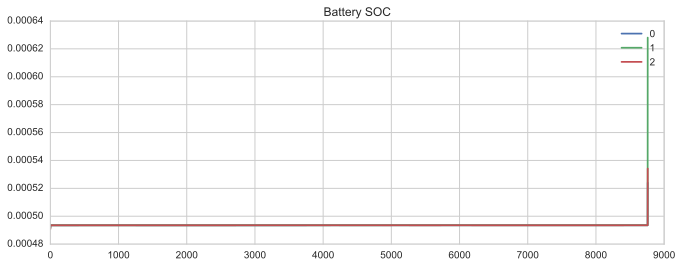

In [228]:
for n in range(mp.get_network().num_bats): 
    plot([mp.networks[i].batteries[n].E for i in range(mp.timesteps)], label=n)
legend()
title("Battery SOC")

In [229]:
solver.problem.phi

1287.6102233606505

In [216]:
[mp.networks[i].batteries[0].E for i in range(mp.timesteps)]

[4.999999977016898e-06,
 4.999999999538905e-06,
 4.99999999953892e-06,
 4.99999999953892e-06,
 4.999999999538915e-06,
 4.999999999538917e-06,
 4.999999999539001e-06,
 4.999999999539579e-06,
 4.9999999995402775e-06,
 4.999999999540192e-06,
 4.999999999538167e-06,
 4.999999999539103e-06,
 4.999999999538316e-06,
 4.99999999953896e-06,
 4.9999999995388985e-06,
 4.999999999538825e-06,
 4.99999999953962e-06,
 4.999999999538894e-06,
 4.9999999995416954e-06,
 4.999999999537539e-06,
 4.999999999538648e-06,
 4.999999999538166e-06,
 4.999999999535875e-06,
 4.999999999538736e-06,
 4.9999999995389206e-06,
 4.999999999538918e-06,
 4.999999999538913e-06,
 4.9999999995389206e-06,
 4.999999999538988e-06,
 4.999999999539186e-06,
 4.999999999540318e-06,
 4.999999999537842e-06,
 4.9999999995384005e-06,
 4.999999999538927e-06,
 4.999999999538916e-06,
 4.99999999953891e-06,
 4.999999999538953e-06,
 4.9999999995389265e-06,
 4.999999999539095e-06,
 4.999999999541173e-06,
 4.999999999542143e-06,
 4.99999999953

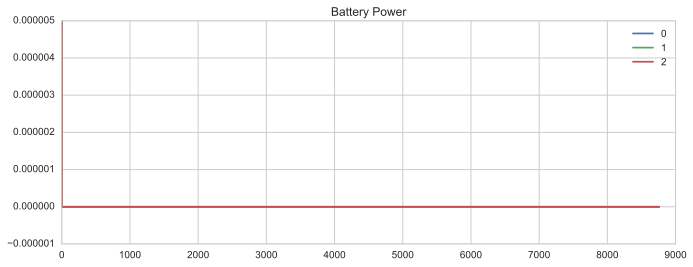

In [217]:
for n in range(mp.get_network().num_bats): 
    plot([mp.networks[i].batteries[n].P for i in range(mp.timesteps)], label=n)
legend()
title("Battery Power")

In [184]:
for n in range(mp.get_network().num_loads): 
    plot([mp.networks[i].loads[n].P for i in range(mp.timesteps)], label=n)
legend()
title("Load Power")

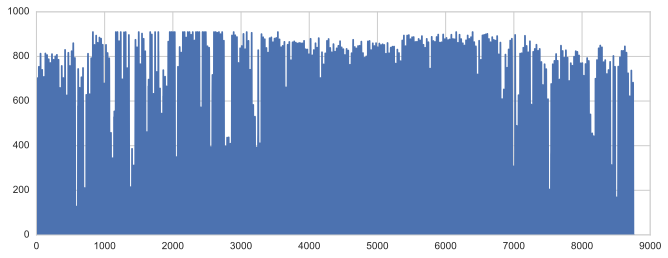

In [185]:
mp.generate_solar_profiles()
plot(mp.solar_profile_map[0])

In [ ]:
mp.get_load(1, 1).P

In [ ]:
plot(mp.load_profile_map[0])